In [28]:
from __future__ import division

import subprocess,os

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import swap

In [11]:
def fetch_parameters(config):

    # Open Configuration File 
    p = swap.Configuration(config)
    params = p.parameters

    return params

In [39]:
def fetch_num_days(params):
    days = int(subprocess.check_output("find %s_*/ -maxdepth 1 -type d -print "
                                       "| wc -l"%params['survey'], shell=True))

    return int(days)

In [12]:
def fetch_classifications(filename):
   
    try:
        dat = Table.read(filename,format='ascii')
    except:
        print "Did not find %s"%filename
        sys.exit()
    else:
        return dat

In [13]:
def fetch_filelist(params, kind='detected'):
     
    # ------------------------------------------------------------------
    # Load up detected subjects... 
    #print "Fetching list of %s files created by GZX..."%kind

    try:
        cmd = "ls %s_*/*%s_catalog.txt"%(params['survey'], kind)
        cmdout = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
        filelist = cmdout.stdout.read().splitlines()
        
    except:
        print "No '%s' files found! Aborting..."%kind
        print ""
        sys.exit()
        
    return filelist

In [ ]:
def generate_SWAP_eval_report(detectedfilelist, rejectedfilelist, subjects, 
                                outname, smooth_or_not=True):

    recall, precision, accuracy = [], [], []
    
    for dfile, rfile in zip(detectedfilelist, rejectedfilelist):
        
        predicted_smooth = fetch_classifications(dfile)
        predicted_not = fetch_classifications(rfile)
        
        gzx = vstack([predicted_smooth['zooid','P','Nclass'], 
                      predicted_not['zooid','P','Nclass']])
        
        # For each subject in detected/rejected, find label in subjects
        result = find_indices(subjects['SDSS_id'], gzx['zooid'])
        gz2 = subjects[result]

        value = int(smooth_or_not)
        
        actually_smooth = gz2[gz2['GZ2_label'] == value]
        actually_not = gz2[gz2['GZ2_label'] != value]
        

        # Indices in GZ2 of the predicted smooth
        tps_idx = find_indices(gz2['SDSS_id'],predicted_smooth['zooid'])

        # Indices in GZ2 of the predicted not
        tns_idx = find_indices(gz2['SDSS_id'], predicted_not['zooid'])


        # True Positives (predicted 'smooth' == actually smooth)
        tps = sum(gz2['GZ2_label'][tps_idx]==value)
        
        # False Positives (predicted 'smooth' but actually NOT)
        fps = sum(gz2['GZ2_label'][tps_idx]!=value)
        
        # True Negatives (predicted 'not' == actually not)
        tns = sum(gz2['GZ2_label'][tns_idx]!=value)
        
        # False Negatives (predicted 'not' but actually SMOOTH)
        fns = sum(gz2['GZ2_label'][tns_idx]==value)
        
        if predicted_smooth and predicted_not: 
            recall.append(float(tps)/float(len(actually_smooth)))
            precision.append(float(tps)/float(len(predicted_smooth)))
            accuracy.append(float(tps + tns)/float(tps+fps+tns+fns))
        else:
            recall.append(0.)
            precision.append(0.)
            accuracy.append(0.)          
            
    evaluation = Table(data=(accuracy, precision, recall), 
                      names=('accuracy','precision','recall'))
    evaluation.write('GZXevalution_%s.txt'%outname, format='ascii')

    return accuracy, precision, recall

In [44]:
def plot_GZX_evaluation(axes, num_days, accuracy, precision, recall):

    days = np.arange(num_days)

    axes.plot(days, accuracy, c='r', label='Accuracy')
    axes.plot(days, precision, c='g', label='Precision')
    axes.plot(days, recall, c='b', label='Recall')
    axes.legend(loc='best')

    axes.set_xlim(0,num_days)
    axes.set_ylim(0.5, 1.0)

    axes.set_xlabel('Days in GZ2 project',fontsize=16,fontweight='bold')
    axes.set_ylabel('Per cent',fontsize=16,fontweight='bold')


In [52]:
def compare_evaluation_plots(config1, config2):
    
    fig = plt.figure(figsize=(16,8))

    i=0
    for config in [config1, config2]:
        outname = config[len('update_'):-len('.config')]
        
        params = fetch_parameters(config)
        days = fetch_num_days(params)

        
        try:    
            eval_report = Table.read('GZXevalution_%s.txt'%outname,format='ascii')
            
            recall = eval_report['recall']
            accuracy = eval_report['accuracy']
            precision = eval_report['precision']
            
        except:
            print "Shit... we have a problem and this shit is going to crash..."
            meta = swap.read_pickle(params['metadatafile'], 'storage')
            subjects = meta.subjects
    
            accuracy, precision, recall = generate_SWAP_eval_report(detectedfilelist, 
                                                            rejectedfilelist, 
                                                            subjects, outname, 
                                                            smooth_or_not=True)
        ax = fig.add_subplot(121+i)
        ax.grid(linestyle='dotted',linewidth=.5)
        plot_GZX_evaluation(ax, days, accuracy, precision, recall)
        i+=1
    
    #plt.savefig("GZX_evaluation_%s.png"%outfile)
    plt.show()
    plt.close()

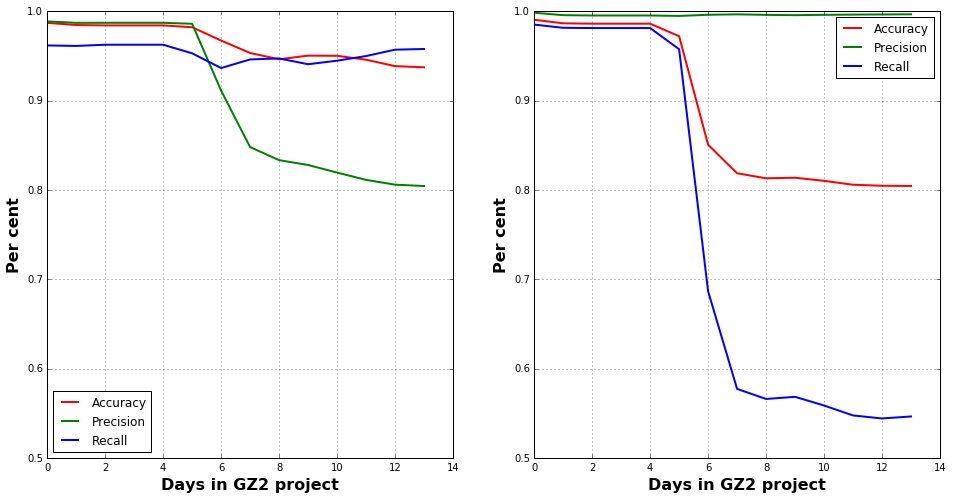

In [53]:
filenames1 = {'S_featornot':'update_sup_0.5_trainfirst_flipfeature2.config',
             'S_smoothornot':'update_sup_0.5_trainfirst_standard2.config',
             'SU_featornot':'update_sup_unsup_0.5_trainfirst_flipfeature2.config',
             'SU_smoothornot':'update_sup_unsup_0.5_trainfirst_standard2.config',
             'S_featornot_p5':'update_sup_PLPD5_p5_flipfeature2.config',
             'S_smoothornot_p5':'update_sup_PLPD5_p5_standard2.config'}

filenames2 = filenames1

interact(compare_evaluation_plots, config1=filenames1, config2=filenames2);